In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from omegaconf import OmegaConf
import datetime
import os
import torch
from pkg import DEVICE
from utils import NEURONS_302
from models._utils import *
from scipy import stats

/om2/user/lrvenan/miniconda/envs/worm-graph/lib/python3.9/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [3]:
%matplotlib inline

In [29]:
exp_log_dir = '/om2/user/lrvenan/worm-graph/logs/2num_worms_ex/transformer/num_worms_exp_07_27' # Path to the folder with all logs from the scaling laws experiment
exp_log_dir2 = '/om2/user/lrvenan/worm-graph/logs/2num_worms_ex/lstm/num_worms_exp_07_23'

key = sl_log_dir.split('/')[-1]
key = key.split('_exp')[0]
print('Experiment key: {}'.format(key))

Experiment key: num_worms


# Time per epoch
---

In [30]:
def time_per_epoch_plot(exp_log_dir, key='num_worms', log_scale=True):
    if key == 'num_worms':
        key_name = 'Number of worms'
    elif key == 'num_named_neurons':
        key_name = 'Number of named neurons'
    elif key == 'loss':
        key_name = 'Loss'
    elif key == 'seq_len':
        key_name = 'Sequence length'
    elif key == 'num_samples':
        key_name = 'Number of samples'
    elif key == 'hidden_size':
        key_name = 'Hidden size'
    elif key == 'worm_timesteps':
        key_name = 'Worm timesteps'
    elif key == 'optimizer':
        key_name = 'Optimizer'
    elif key == 'learn_rate':
        key_name = 'Learning rate'
    else:
        raise ValueError('key must be num_worms, num_named_neurons, loss, seq_len, num_samples, hidden_size, worm_timesteps, optimizer or learn_rate')

    # Store seconds per epoch, number of named neurons and number of worms
    seconds_per_epoch = []
    num_named_neurons = []
    num_worms = []
    loss_type = []
    seq_len = []
    num_samples = []
    hidden_size = []
    worm_timesteps = []
    optimizer = []
    lr = []

    # Loop over all folders inside the log directory
    for folder in os.listdir(exp_log_dir):
        # Load the config file inside each folder
        pipeline_info = OmegaConf.load(os.path.join(exp_log_dir, folder, 'pipeline_info.yaml')).submodule
        train_info = OmegaConf.load(os.path.join(exp_log_dir, folder, 'train_info.yaml'))
        # Extract seconds_per_epoch from the config file
        seconds_per_epoch.append(train_info['seconds_per_epoch'])
        # Extract num_named_neurons from the config file
        num_named_neurons.append(pipeline_info['dataset_train']['num_named_neurons'])
        # Extract num_worms from the config file
        num_worms.append(pipeline_info['dataset_train']['num_worms'])
        # Extract loss_type from the config file
        loss_type.append(pipeline_info['model']['loss'])
        # Extract seq_len from the config file
        seq_len.append(pipeline_info['train']['seq_len'])
        # Extract num_samples from the config file
        num_samples.append(pipeline_info['train']['num_samples'])
        # Extract hidden_size from the config file
        hidden_size.append(pipeline_info['model']['hidden_size'])
        # Extract worm_timesteps from the config file
        worm_timesteps.append(train_info['worm_timesteps'])
        # Extract optimizer
        optimizer.append(pipeline_info['train']['optimizer'])
        # Extract learn_rate
        lr.append(pipeline_info['train']['learn_rate'])

    # Create a dataframe with the seconds per epoch, number of named neurons and number of worms
    df = pd.DataFrame({'seconds_per_epoch': seconds_per_epoch, 'num_named_neurons': num_named_neurons,
    'num_worms': num_worms, 'loss': loss_type, 'seq_len': seq_len, 'num_samples': num_samples, 'hidden_size': hidden_size,
    'worm_timesteps': worm_timesteps, 'optimizer': optimizer, 'learn_rate': lr})

    # Plot the seconds per epoch vs the number of worms
    fig, ax = plt.subplots(figsize=(10, 5))
    # Use whitegrid style
    sns.set_style('whitegrid')
    sns.set_palette('tab10')
    # Plot the data using sns bar plot
    sns.barplot(data=df, x=key, y='seconds_per_epoch', ax=ax)
    # Set the x axis and y axis labels according to the key
    plt.xlabel(key_name)
    plt.ylabel('Seconds per epoch')
    # Set title according to the key
    plt.title('Seconds per epoch vs {}'.format(key_name))
    plt.tight_layout()
    plt.show()

    if key == 'num_worms' or key == 'seq_len' or key == 'num_samples' or key == 'hidden_size' or key == 'worm_timesteps':
        # Plot the seconds per epoch vs the number of worms
        fig, ax = plt.subplots(figsize=(10, 5))
        # Use whitegrid style
        sns.set_style('whitegrid')
        sns.set_palette('tab10')
        # Plot the data using sns scatterplot
        sns.scatterplot(data=df, x=key, y='seconds_per_epoch', ax=ax)
        # Regression line
        if log_scale:
            # Use log scale for the x axis and y axis
            ax.set_xscale('log')
            ax.set_yscale('log')
            slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(df[key]), np.log(df['seconds_per_epoch']))
            # Add the regression line to the plot using sns lineplot
            x = np.linspace(df[key].min(), df[key].max(), 1000)
            y = np.exp(intercept) * x ** slope
        else:
            slope, intercept, r_value, p_value, std_err = stats.linregress(df[key], df['seconds_per_epoch'])
            # Add the regression line to the plot using sns lineplot
            x = np.linspace(df[key].min(), df[key].max(), 1000)
            y = slope * x + intercept
        # Write the regression line equation as a label
        label = 'y = {}x + {}\n~ R^2: {}'.format(round(slope, 5), round(intercept, 5), round(r_value ** 2, 5))
        sns.lineplot(x=x, y=y, ax=ax, label=label, color='red')
        # Use dashed line style
        ax.lines[0].set_linestyle("--")
        # Reduce the opacity of the regression line
        ax.lines[0].set_alpha(0.5)
        # Reduce size of the regression line
        ax.lines[0].set_linewidth(1)

        # Set the x axis and y axis labels according to the key
        plt.xlabel(key_name)
        plt.ylabel('Seconds per epoch')
        # Set title according to the key
        plt.title('Seconds per epoch vs {}'.format(key_name))
        plt.tight_layout()
        plt.show()
        # Save the plot
        fig.savefig('../scaling_laws/seconds_per_epoch_plot.png', dpi=300)


    # Return df, fig and ax so we can customize the plot if we want
    return df, fig, ax

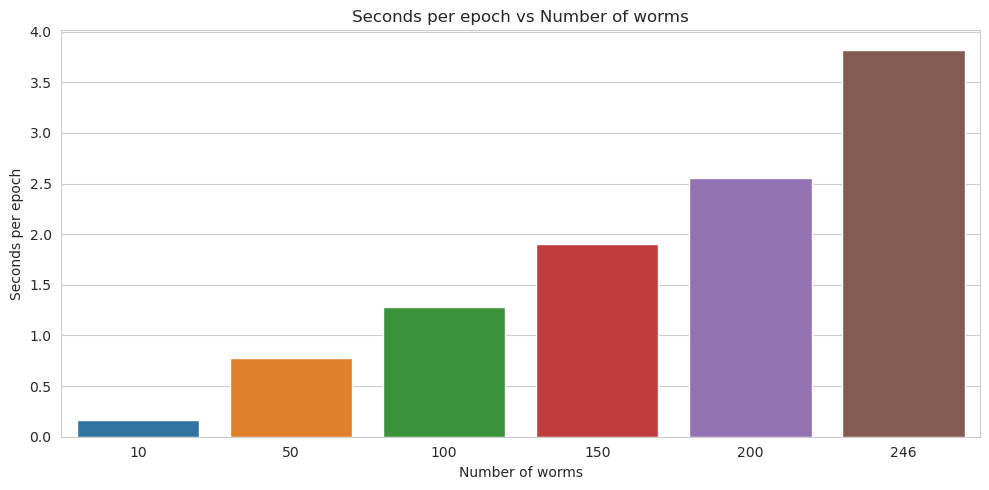

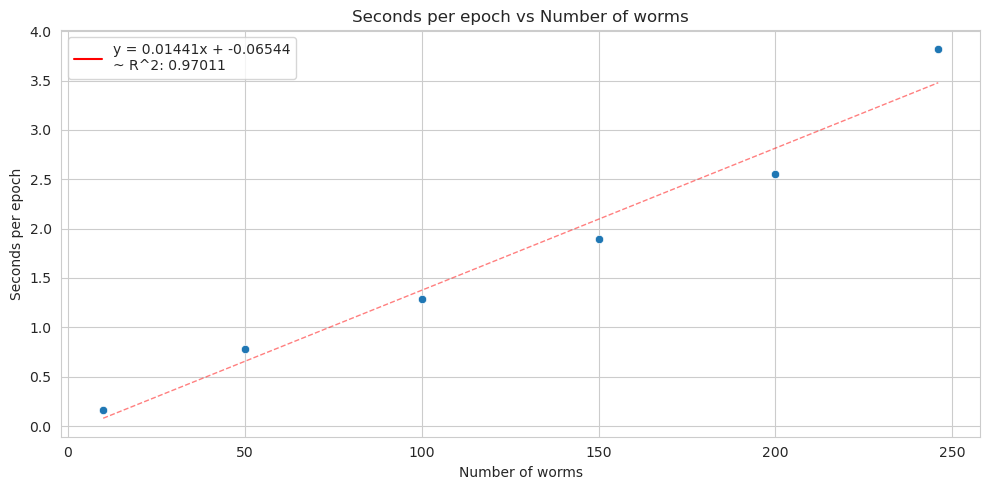

In [32]:
df, fig, ax = time_per_epoch_plot(exp_log_dir2, key=key, log_scale=False)

# Test losses
---

In [8]:
# Define a function to calculate convergence time
def convergence_epoch(y_values, x_values, threshold=1e-5):
    # Calculate the absolute difference between successive y-values
    diffs = np.abs(np.diff(y_values))

    # Find the first time the difference is less than the threshold
    indices = np.where(diffs < threshold)

    if len(indices[0]) > 0:
        return x_values[indices[0][0]]
    else:
        return None  # Convergence didn't occur

In [9]:
def test_losses_plot(exp_log_dir, key='num_worms', threshold=1e-5, window=10, xlim=None):

    # Cycle tab10 colors
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown',
    'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

    if key == 'num_worms':
        key_name = 'Worms'
    elif key == 'num_named_neurons':
        key_name = 'Named neurons'
    elif key == 'loss':
        key_name = 'Loss'
    elif key == 'seq_len':
        key_name = 'Sequence length'
    elif key == 'num_samples':
        key_name = 'Number of samples'
    elif key == 'hidden_size':
        key_name = 'Hidden size'
    elif key == 'worm_timesteps':
        key_name = 'Worm timesteps'
    elif key == 'optimizer':
        key_name = 'Optimizer'
    elif key == 'learn_rate':
        key_name = 'Learning rate'
    else:
        raise ValueError('key must be num_worms, num_named_neurons, loss, seq_len, num_samples, hidden_size, optimizer or learn_rate')

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.set_style('whitegrid')
    sns.set_palette('tab10')

    # Loop over all folders inside the log directory
    for i, folder in enumerate(os.listdir(exp_log_dir)):
        # Load the config file inside each folder
        pipeline_info = OmegaConf.load(os.path.join(exp_log_dir, folder, 'pipeline_info.yaml')).submodule
        train_info = OmegaConf.load(os.path.join(exp_log_dir, folder, 'train_info.yaml'))
        # Extract the number of worms, number of named neurons or loss type from the config file
        if key == 'num_worms' or key == 'num_named_neurons':
            key_value = pipeline_info['dataset_train'][key]
        elif key == 'loss':
            key_value = pipeline_info['model'][key]
        elif key == 'seq_len':
            key_value = pipeline_info['train'][key]
        elif key == 'num_samples':
            key_value = pipeline_info['train'][key]
        elif key == 'hidden_size':
            key_value = pipeline_info['model'][key]
        elif key == 'worm_timesteps':
            key_value = train_info[key]
        elif key == 'optimizer':
            key_value = pipeline_info['train'][key]
        elif key == 'learn_rate':
            key_value = pipeline_info['train'][key]
        # Load the dataframe with the losses
        loss_df = pd.read_csv(os.path.join(exp_log_dir, folder, 'loss_curves.csv'))
        # if test loss == inf, skip
        if np.sum(loss_df['test_losses'] == np.inf) > 0:
            continue
        # Plot the test losses
        label = '{} {}'.format(key_value, key_name)
        sns.lineplot(data=loss_df, x='epochs', y='test_losses', ax=ax, label=label, color=colors[i])
        # Vertical line conv epoch
        conv_epoch = convergence_epoch(loss_df['test_losses'].rolling(window).mean().values, loss_df['epochs'].values, threshold=threshold)
        if conv_epoch is not None:
            ax.axvline(conv_epoch, color=colors[i], linestyle='--', alpha=0.5)
    
    # Plot just one base test loss
    sns.lineplot(data=loss_df, x='epochs', y='base_test_losses', ax=ax, label='Baseline', color='black')
    # Dash the base test loss line
    ax.lines[-1].set_linestyle("--")
    # Reduce the opacity of the base test loss line
    ax.lines[-1].set_alpha(0.7)
    # Reduce size of the base test loss line
    ax.lines[-1].set_linewidth(0.7)

    if xlim is not None:
        ax.set_xlim(xlim)

    # Set the x axis and y axis labels
    plt.xlabel('Epochs')
    plt.ylabel('Test loss')
    # Set title
    plt.title('Test loss vs epochs')
    plt.tight_layout()
    # Save the plot
    fig.savefig('../scaling_laws/test_loss_vs_epochs.png', dpi=300)
    plt.show()

    return loss_df, fig, ax

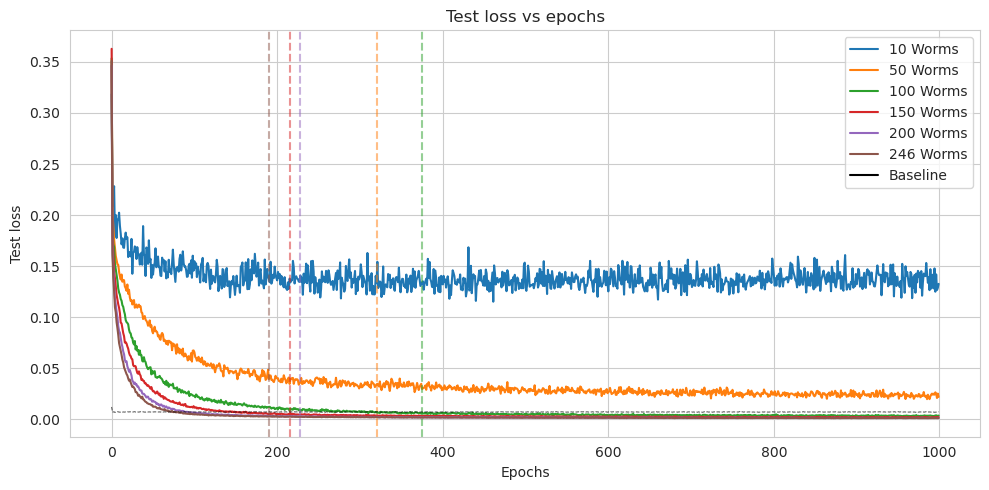

In [33]:
loss_df, fig, ax = test_losses_plot(exp_log_dir2, key=key, threshold=1e-6, window=30, xlim=None)

# Scaling laws
---

- Test loss (plateau) vs. number of worms
- Test loss (plateau) vs. worm timesteps
- Test loss (plateau) vs. hidden size
- Test loss (plateau) vs. number of named neurons
- Test loss (plateau) vs. sequence length
- Test loss (plateau) vs. number of samples

In [34]:
def find_plateau_epoch(loss_df, threshold):
    # Extract losses and epochs from the loss dataframe
    test_losses = loss_df['test_losses'].values
    epochs = loss_df['epochs'].values

    # Loop over 100 window sizes
    for window_size in range(10, 110):
        # Calculate a moving average of the test losses to smooth the curve
        smoothed_losses = np.convolve(test_losses, np.ones(window_size)/window_size, mode='valid')

        # Calculate the derivative of the smoothed losses
        derivatives = np.diff(smoothed_losses)

        # Identify the epoch when the absolute derivative first becomes close to zero.
        plateau_epoch = next((i for i, deriv in enumerate(derivatives) if abs(deriv) < threshold), None)

        # If the plateau epoch is not None, then we found the epoch when the loss curve plateaus
        if plateau_epoch is not None:
            # Return the plateau epoch and the mean loss after the plateau epoch
            plateau_mean_loss = np.mean(test_losses[plateau_epoch-window_size//2:plateau_epoch+window_size//2])
            return plateau_epoch, plateau_mean_loss, window_size, threshold
        
    # If plateau epoch is None, increase the threshold and try again
    return find_plateau_epoch(loss_df, threshold * 1.2)

In [35]:
def scaling_law_plot(exp_log_dir, key='num_worms', window=10, threshold=1e-5, log_scale=True, x_predict=None):

    if key == 'num_worms':
        key_name = 'Worms'
    elif key == 'num_named_neurons':
        key_name = 'Named neurons'
    elif key == 'seq_len':
        key_name = 'Sequence length'
    elif key == 'num_samples':
        key_name = 'Number of samples'
    elif key == 'hidden_size':
        key_name = 'Hidden size'
    elif key == 'worm_timesteps':
        key_name = 'Worm timesteps'
    else:
        raise ValueError('key must be num_worms, num_named_neurons, seq_len, num_samples, hidden_size or worm_timesteps')
        

    # Store plateau epoch, window size and threshold for each log folder
    plateau_epochs = []

    # Store number of worms and mean loss after plateau
    plateau_losses = []
    num_worms = []
    num_named_neurons = []
    seq_len = []
    num_samples = []
    hidden_size = []
    worm_timesteps = []

    # Loop over the folders inside the log directory
    for i, folder in enumerate(os.listdir(exp_log_dir)):
        # Load the config file inside each folder
        pipeline_info = OmegaConf.load(os.path.join(exp_log_dir, folder, 'pipeline_info.yaml')).submodule
        train_info = OmegaConf.load(os.path.join(exp_log_dir, folder, 'train_info.yaml'))
        # Extract num_worms from the config file
        num_worms.append(pipeline_info['dataset_train']['num_worms'])
        # Extract num_named_neurons from the config file
        num_named_neurons.append(pipeline_info['dataset_train']['num_named_neurons'])
        # Extract seq_len from the config file
        seq_len.append(pipeline_info['train']['seq_len'])
        # Extract num_samples from the config file
        num_samples.append(pipeline_info['train']['num_samples'])
        # Extract hidden_size from the config file
        hidden_size.append(pipeline_info['model']['hidden_size'])
        # Extract worm_timesteps from the config file
        worm_timesteps.append(train_info['worm_timesteps'])
        # Load the loss dataframe inside each folder
        loss_df = pd.read_csv(os.path.join(exp_log_dir, folder, 'loss_curves.csv'))
        # Find the epoch when the loss curve plateaus
        plateau_epoch = convergence_epoch(loss_df['test_losses'].rolling(window).mean().values, loss_df['epochs'].values, threshold=threshold)
        if plateau_epoch is not None:
            # Select line where epoch = plateau_epoch
            # plateau_loss = loss_df[loss_df['epochs'] == plateau_epoch]['test_losses'].values[0]
            plateau_loss = loss_df['test_losses'].min()
        else:
            raise ValueError('Plateau loss is None. Adjust threshold and/or moving average window size.')
        print('Plateau epoch: {}, plateau loss: {}'.format(plateau_epoch, round(plateau_loss,2)))
        # Store plateau epoch, mean loss, window size and threshold
        plateau_epochs.append(plateau_epoch)
        plateau_losses.append(plateau_loss)
        # Extract loss baseline test value in plateau epoch
        baseline_test_loss = loss_df['base_test_losses'].values[plateau_epoch]

    # Create a dataframe with the plateau epoch, window size and threshold
    df = pd.DataFrame({'plateau_epoch': plateau_epochs, 'plateau_loss': plateau_losses,
                       'baseline': baseline_test_loss,
                       'num_worms': num_worms, 'num_named_neurons': num_named_neurons, 'seq_len': seq_len,
                       'num_samples': num_samples, 'hidden_size': hidden_size, 'worm_timesteps': worm_timesteps})
    
    # Plot the seconds per epoch vs the number of worms
    fig, ax = plt.subplots(figsize=(10, 5))
    # Use whitegrid style
    sns.set_style('whitegrid')
    sns.set_palette('tab10')
    # Plot the data using sns bar plot
    sns.barplot(data=df, x=key, y='plateau_loss', ax=ax)
    # Plot horizontal line on average base test loss
    ax.axhline(np.mean(df['baseline']), color='black', linestyle='--', alpha=0.7, label='Baseline test loss')
    # Set the x axis and y axis labels according to the key
    plt.xlabel(key_name)
    plt.ylabel('Test loss')
    # Set title according to the key
    plt.title('Test loss vs {}'.format(key_name))
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot plateau loss vs number of worms
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.set_style('whitegrid')
    sns.set_palette('tab10')
    sns.scatterplot(data=df, x=key, y='plateau_loss', ax=ax, label='Test loss')
    # Plot baseline test loss
    sns.lineplot(data=df, x=key, y='baseline', ax=ax, label='Baseline test loss', alpha=0.7)
    if log_scale:
        # Use log scale for the x axis and y axis
        ax.set_xscale('log')
        ax.set_yscale('log')
        # Regression line for the plot above
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(df[key]), np.log(df['plateau_loss']))
        # Add the regression line to the plot above using sns lineplot
        x = np.linspace(df[key].min(), df[key].max(), 1000)
        y = np.exp(intercept) * x ** slope
    else:
        # Regression line for the plot above
        slope, intercept, r_value, p_value, std_err = stats.linregress(df[key], df['plateau_loss'])
        # Add the regression line to the plot above using sns lineplot
        x = np.linspace(df[key].min(), df[key].max(), 1000)
        y = slope * x + intercept
    # Write the regression line equation as a label
    label = 'y = {}x + {}\n~ R^2: {}'.format(round(slope, 5), round(intercept, 5), round(r_value ** 2, 5))
    sns.lineplot(x=x, y=y, ax=ax, label=label, color='red', alpha=0.7)
    # Use dashed line style
    ax.lines[0].set_linestyle("--")
    plt.xlabel(key_name)
    plt.ylabel('Test loss')
    # Set title
    plt.title('Test loss vs {}'.format(key_name))
    plt.tight_layout()
    plt.show()
    # Save the plot
    fig.savefig('../scaling_laws/test_loss_vs_{}.png'.format(key), dpi=300)

    # Predict plateau loss using the regression line
    if x_predict:
        if log_scale:
            predicted_plateau_loss = np.exp(intercept) * x_predict ** slope
        else:
            predicted_plateau_loss = slope * x_predict + intercept

        print("For x = {}, the predicted test loss is {}".format(x_predict, predicted_plateau_loss))

    return df, fig, ax

Plateau epoch: 28, plateau loss: 0.12
Plateau epoch: 138, plateau loss: 0.02
Plateau epoch: 162, plateau loss: 0.0
Plateau epoch: 171, plateau loss: 0.0
Plateau epoch: 132, plateau loss: 0.0
Plateau epoch: 121, plateau loss: 0.0


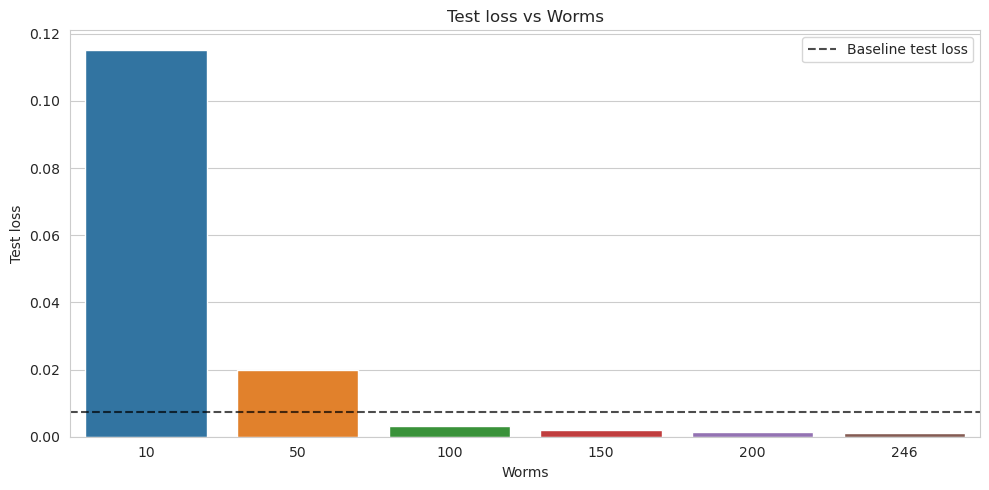

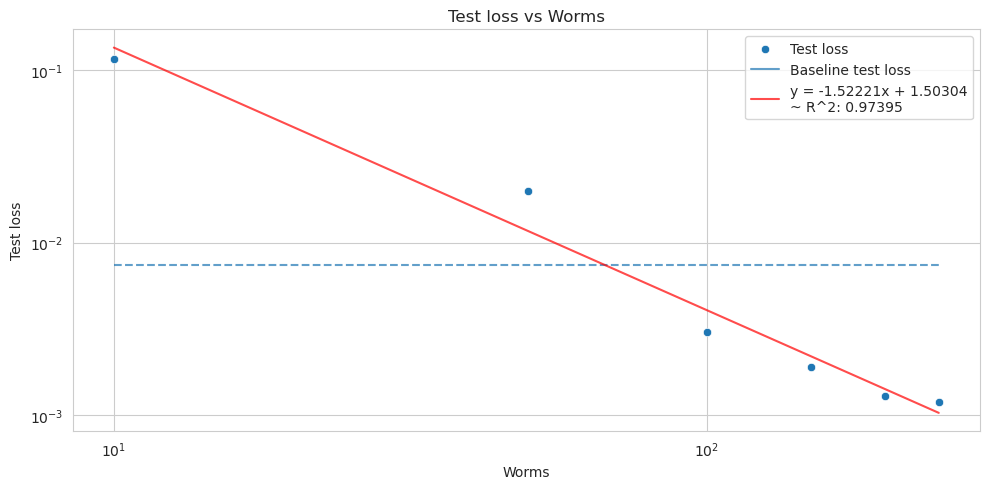

In [37]:
df, fig, ax = scaling_law_plot(exp_log_dir2, key=key, window=15, threshold=1e-5, log_scale=True, x_predict=None)

Plateau epoch: 227, plateau loss: 0.04
Plateau epoch: 115, plateau loss: 0.02
Plateau epoch: 106, plateau loss: 0.01
Plateau epoch: 111, plateau loss: 0.01
Plateau epoch: 90, plateau loss: 0.01
Plateau epoch: 78, plateau loss: 0.01


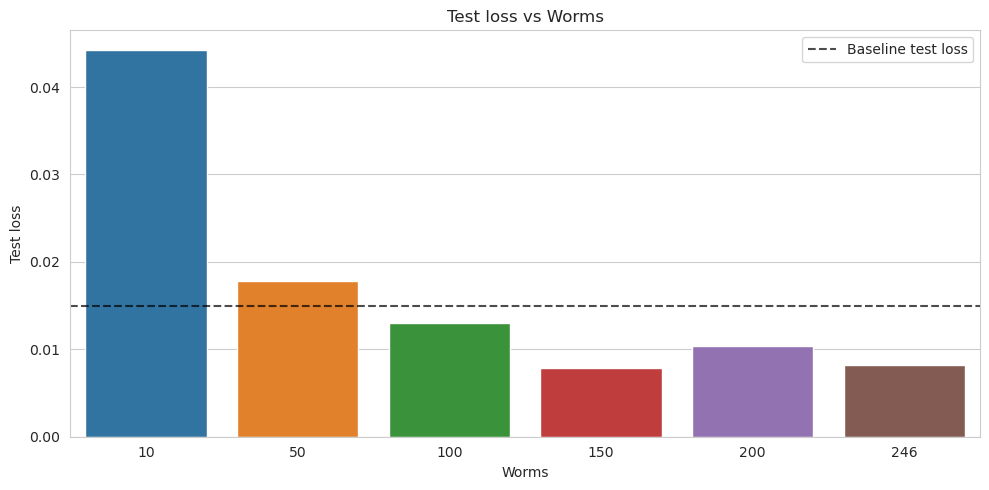

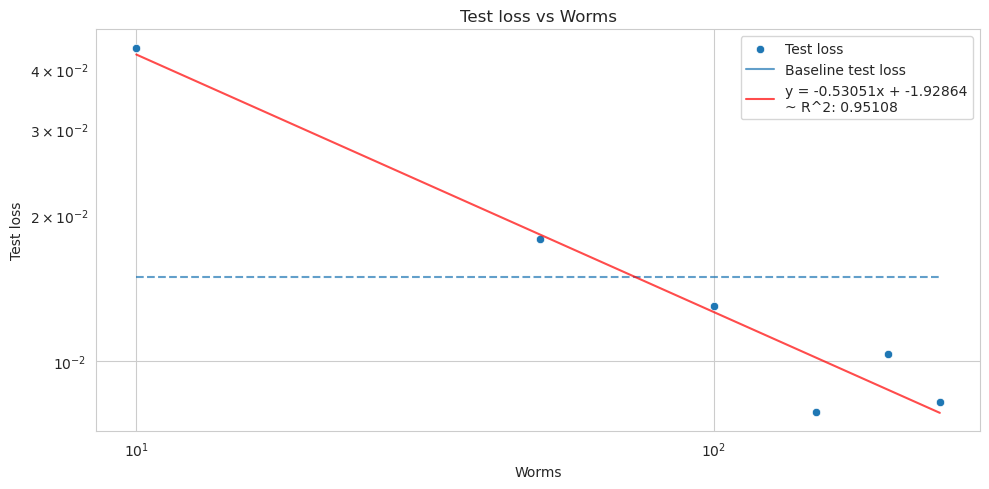

In [40]:
df2, fig, ax = scaling_law_plot(exp_log_dir, key=key, window=15, threshold=1e-5, log_scale=True, x_predict=None)

In [41]:
df.head()

,plateau_epoch,plateau_loss,baseline,num_worms,num_named_neurons,seq_len,num_samples,hidden_size,worm_timesteps
0,28,0.115266,0.007384,10,all,60,16,256,6959
1,138,0.019884,0.007384,50,all,60,16,256,37464
2,162,0.003052,0.007384,100,all,60,16,256,72497
3,171,0.001911,0.007384,150,all,60,16,256,116054
4,132,0.001286,0.007384,200,all,60,16,256,142422


In [42]:
df2.head()

,plateau_epoch,plateau_loss,baseline,num_worms,num_named_neurons,seq_len,num_samples,hidden_size,worm_timesteps
0,227,0.044274,0.014912,10,all,120,16,256,8083
1,115,0.017828,0.014912,50,all,120,16,256,33816
2,106,0.012987,0.014912,100,all,120,16,256,74147
3,111,0.007848,0.014912,150,all,120,16,256,109153
4,90,0.010377,0.014912,200,all,120,16,256,146812


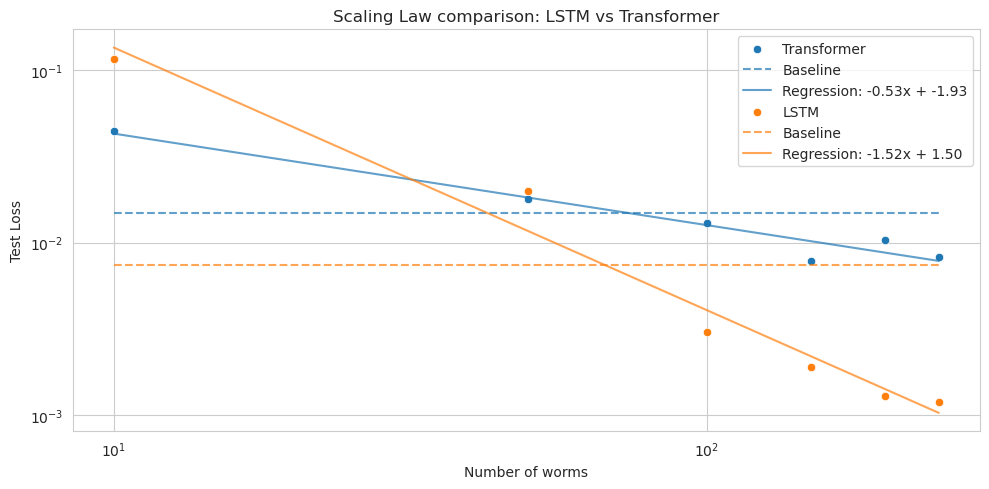

In [58]:
# Plot scaling laws in the same plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Use log scale
ax.set_yscale('log')
ax.set_xscale('log')

# TRANSFORMER
sns.scatterplot(data=df2, x=key, y='plateau_loss', ax=ax, label='Transformer', color='tab:blue')
sns.lineplot(data=df2, x=key, y='baseline', ax=ax, label='Baseline', alpha=0.7, color='tab:blue')
# Dash the baseline
ax.lines[0].set_linestyle("--")
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(df2[key]), np.log(df2['plateau_loss']))
# Add the regression line to the plot above using sns lineplot
xtrans = np.linspace(df2[key].min(), df2[key].max(), 1000)
ytrans = np.exp(intercept) * xtrans ** slope
reg_label = f"Regression: {slope:.2f}x + {intercept:.2f}"
sns.lineplot(x=xtrans, y=ytrans, ax=ax, label=reg_label, alpha=0.7, color='tab:blue')

# LSTM
sns.scatterplot(data=df, x=key, y='plateau_loss', ax=ax, label='LSTM', color='tab:orange')
sns.lineplot(data=df, x=key, y='baseline', ax=ax, label='Baseline', alpha=0.7, color='tab:orange')
# Dash the baseline
ax.lines[2].set_linestyle("--")
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(df[key]), np.log(df['plateau_loss']))
# Add the regression line to the plot above using sns lineplot
xlstm = np.linspace(df[key].min(), df[key].max(), 1000)
ylstm = np.exp(intercept) * xlstm ** slope
reg_label = f"Regression: {slope:.2f}x + {intercept:.2f}"
sns.lineplot(x=xlstm, y=ylstm, ax=ax, label=reg_label, alpha=0.7, color='tab:orange')

plt.title('Scaling Law comparison: LSTM vs Transformer')
plt.xlabel('Number of worms')
plt.ylabel('Test Loss')

plt.legend()
plt.tight_layout()
plt.show()